In [1]:
import fsspec
import xarray as xr
import dask
import intake
import numpy as np
import matplotlib.pyplot as plt
import regionmask

dask.config.set(**{'array.slicing.split_large_chunks': False})

SQM_PER_HA = 10000
cat = intake.open_catalog('./catalog.yaml')


def compute_grid_area(da):
    R = 6.371e6
    total_area = (4 * np.pi * R**2)
    dϕ = np.radians((da['lat'][1]-da['lat'][0]).values)
    dλ = np.radians((da['lon'][1]-da['lon'][0]).values)
    dA = R**2 * np.abs(dϕ * dλ) * np.cos(np.radians(da['lat']))
    areacella = dA * (0 * da + 1)
    
    return areacella / SQM_PER_HA

In [ ]:
lat='00N'
lon='070W'
da_zarin = cat.hansen_emissions_px(lat=lat, lon=lon).to_dask().rename({'x': 'lon', 'y': 'lat'}).coarsen(lon=100, lat=100).sum().load()

In [ ]:
mapper = fsspec.get_mapper(f'gs://carbonplan-scratch/global-forest-emissions/{lat}_{lon}.zarr')
da_americas = xr.open_zarr(mapper)['emissions']
da_area = compute_grid_area(da_americas.isel(year=0, drop=True))
da_americas = (da_americas * da_area).coarsen(lat=100, lon=100).sum().load()

In [ ]:
da_americas_sum = da_americas.sum('year')

In [ ]:
da_zarin.where(da_zarin).plot(vmin=0, vmax=200000)
plt.title('Zarin Emissions')

In [ ]:
da_americas_sum.where(da_americas_sum).plot(vmin=0, vmax=200000)
plt.title('CarbonPlan Emissions')

In [ ]:
((da_zarin - da_americas_sum) / da_zarin).plot(robust=True)
plt.title('% difference')

In [2]:
coarsened_url = f'gs://carbonplan-scratch/global-forest-emissions/americas/3000m/raster_v2.zarr'
mapper = fsspec.get_mapper(coarsened_url)
ds_ameri = xr.open_zarr(mapper)

In [3]:
ds_ameri

,Array,Chunk
Bytes,3.04 GB,3.96 MB
Shape,"(4800, 4400, 18)","(300, 550, 3)"
Count,769 Tasks,768 Chunks
Type,float64,numpy.ndarray


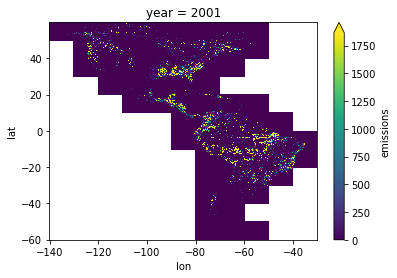

In [4]:
ds_ameri.isel(year=0, lat=slice(None, None, 10), lon=slice(None, None, 10)).emissions.plot(robust=True)

In [5]:
countries = regionmask.defined_regions.natural_earth.countries_110
names = dict(zip(countries.numbers, countries.names))
mask = countries.mask(ds_ameri.emissions)

df = ds_ameri.emissions.groupby(mask).sum().to_pandas()
columns = {k: names[int(k)] for k in df.columns}
df = df.rename(columns=columns)
df.head()

region,Canada,United States of America,Argentina,Chile,Haiti,Dominican Rep.,Bahamas,Falkland Is.,Mexico,Uruguay,...,Venezuela,Guyana,Suriname,France,Ecuador,Puerto Rico,Jamaica,Cuba,Paraguay,Trinidad and Tobago
year,,,,,,,,,,,,,,,,,,,,,
2001,1.665629e+08,4.994093e+08,1.940418e+07,1.641088e+07,534790.366106,2.757105e+06,7840.994271,0.0,3.391460e+07,1.295107e+06,...,3.307795e+07,4.905572e+06,2.117116e+06,1.758630e+06,1.831517e+07,358574.870875,4.194595e+05,3.465577e+06,2.218390e+07,593041.771999
2002,2.512516e+08,5.418003e+08,1.557436e+07,1.789999e+07,359750.601707,2.432375e+06,26780.967068,0.0,3.385235e+07,1.188008e+06,...,2.244509e+07,2.417014e+06,2.079608e+06,1.442426e+06,1.329938e+07,331394.725926,5.074205e+05,2.826279e+06,2.988448e+07,236295.532939
2003,1.915605e+08,4.190557e+08,2.553342e+07,1.860663e+07,244802.462507,2.750389e+06,3588.671842,0.0,3.116662e+07,1.779362e+06,...,2.487260e+07,3.514589e+06,2.192186e+06,1.109127e+06,6.102072e+06,369599.010306,2.994231e+05,1.190008e+06,4.099684e+07,221225.172628
2004,2.877756e+08,5.826786e+08,4.300349e+07,1.905337e+07,543619.001949,5.009216e+06,22236.489783,0.0,3.487434e+07,2.482970e+06,...,2.374789e+07,2.032537e+06,2.834551e+06,2.705648e+06,1.426009e+07,396356.363264,1.244976e+06,3.598286e+06,4.249439e+07,249799.667446
2005,2.760841e+08,5.111113e+08,4.039422e+07,2.342584e+07,511156.398910,6.569203e+06,21260.965624,0.0,4.274049e+07,2.572010e+06,...,2.462971e+07,2.881486e+06,1.865960e+06,1.556060e+06,1.635032e+07,379486.502124,2.613389e+06,2.677111e+06,3.395810e+07,399678.733119


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


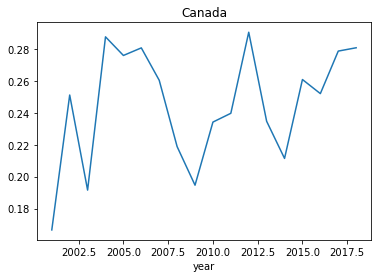

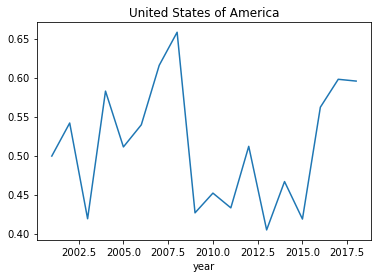

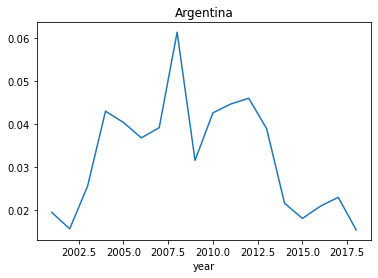

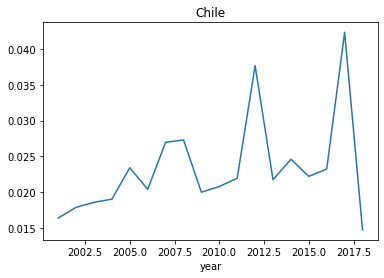

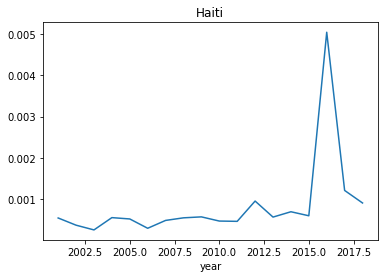

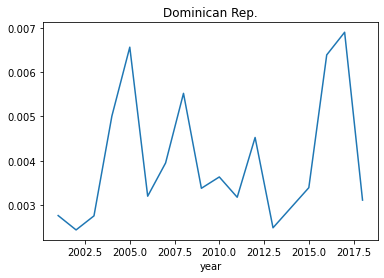

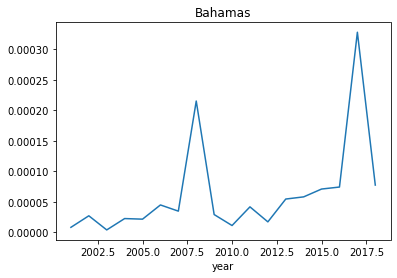

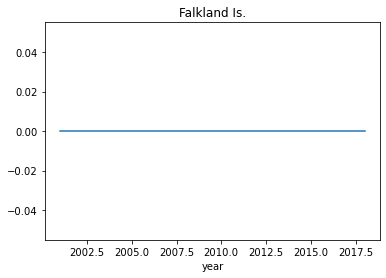

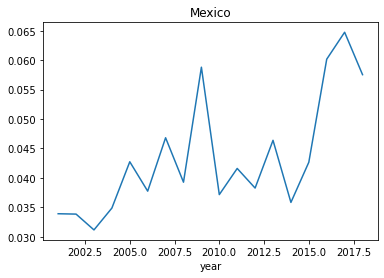

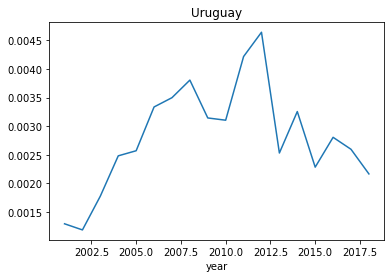

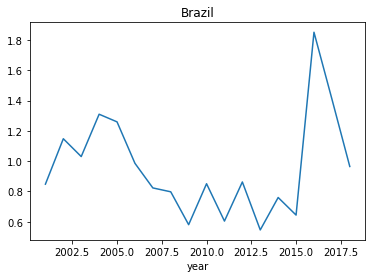

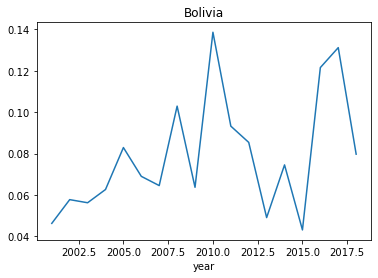

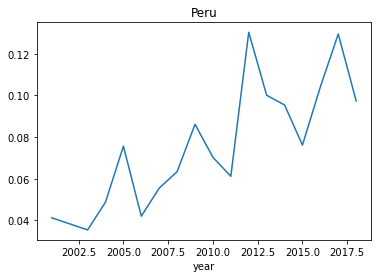

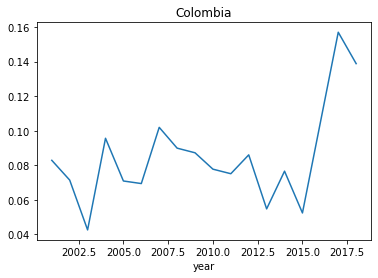

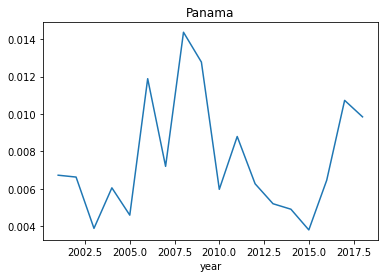

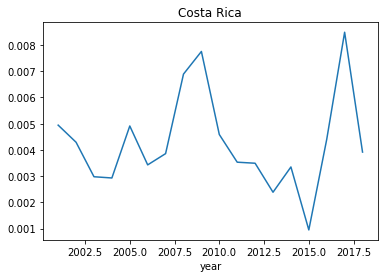

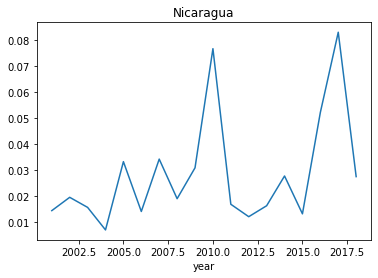

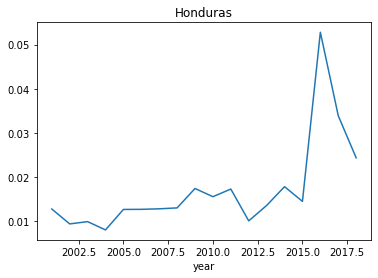

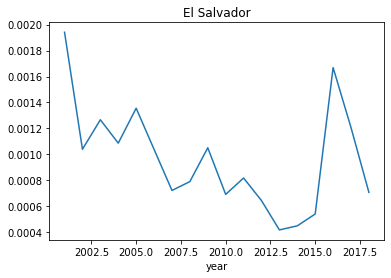

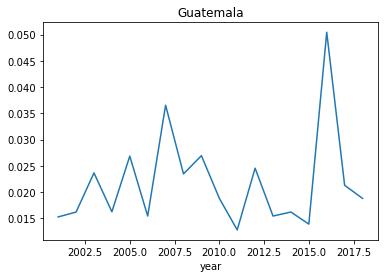

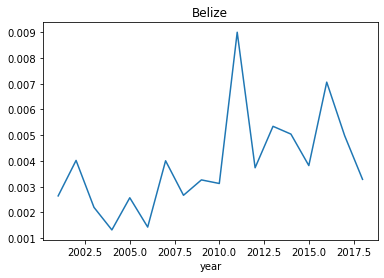

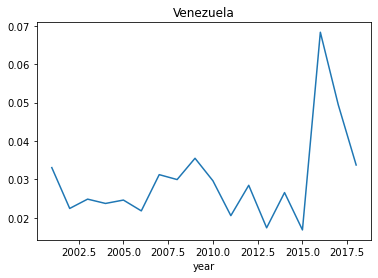

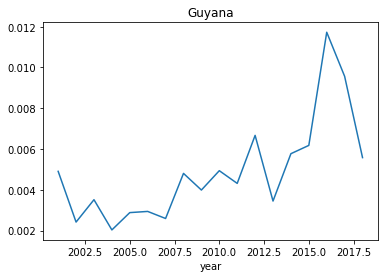

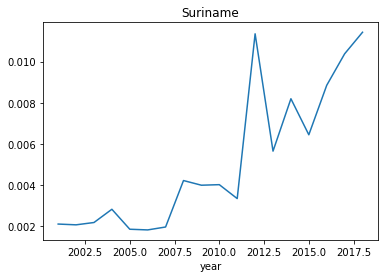

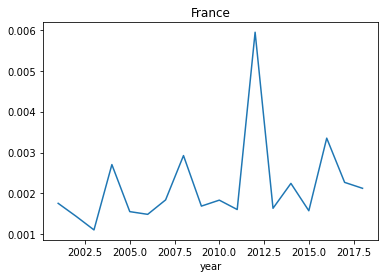

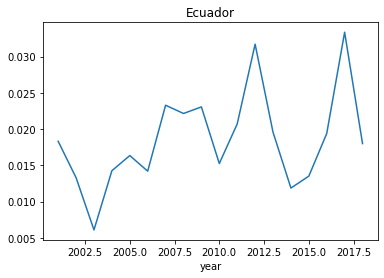

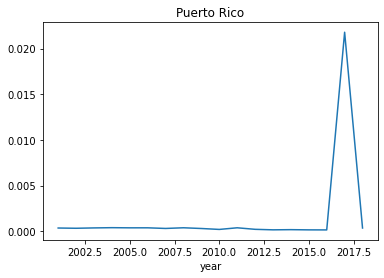

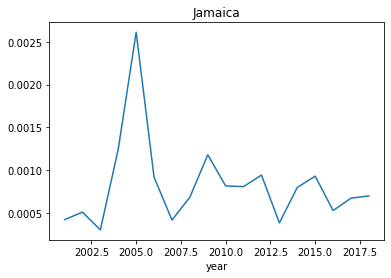

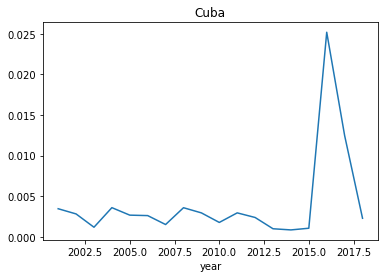

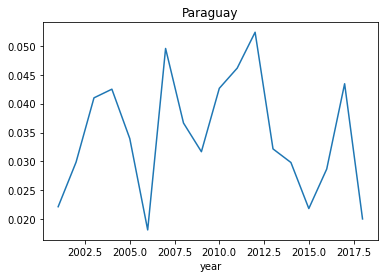

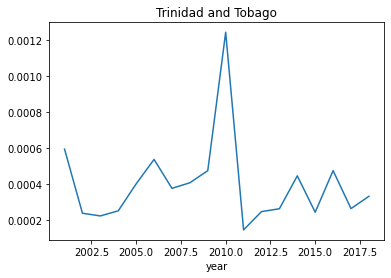

In [6]:
for k, s in df.items():
    plt.figure()
    (s / 1e9).plot()
    plt.title(k)

In [7]:
data = (df / 1e9).to_dict()

In [8]:
out = {}
for k, d in data.items():
    l = []
    for y, v in d.items():
        l.append({"year": y, "emissions": v})
    out[k] = l

In [9]:
import json
with open('data.json', 'w') as f:
    json.dump(out, f, indent=2)